# Price_Indicator_Analysis_MVP

Analysis of common technical analysis indicators on daily price data for different products.

## Data Collection

In [1]:
import pandas as pd
import numpy as np

import requests
import json
import quandl

import datetime

import matplotlib.pyplot as plt

import sqlite3

% matplotlib inline

The first step will be to get data from the [quandl API](https://www.quandl.com/collections/futures).  For this we use an api key generated from signing up for a free quandl account.

We create a list of the symbols for the products we are interested in, which can be found by looking at the [documentation](https://docs.quandl.com/).

Then loop through the products, read the price data into a dataframe, and attach the symbol:dataframe key:value pair to a dictionary object, after selecting the specific information we need.

In [2]:
# Get data from Quandl with api key
api_key = 'Hv95pPh1xQWzt5DFhxS7'

# Create list of symbols for the products we want data for
prod_list = ['CL', 'HO', 'NG', 'GC',
             'SI', 'AD', 'CD', 'EC',
             'BP', 'JY', 'US', 'C',
             'W', 'S', 'ES']

# Create a dict with keys as symbols and values as dataframe of price info
prod_dict = {}

# Iterate through list of prods and add data to dict
for prod in prod_list:
    # Quandl API call
    df = quandl.get('SCF/CME_{p}1_FW'.format(p=prod), authtoken=api_key)
    
    # Drop open interest column and rename Settle column
    df.drop(['Prev. Day Open Interest'], axis=1, inplace=True)
    df.rename(columns={'Open': 'open',
                      'High': 'high',
                      'Low': 'low',
                      'Settle': 'close',
                      'Volume': 'volume'}, inplace=True)
    # Add prod to dict
    prod_dict[prod] = df

Here is some summary information of the Crude Oil ('CL') dataframe

In [3]:
cl = prod_dict['CL']
cl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2005-01-03 to 2014-12-31
Data columns (total 5 columns):
open      2517 non-null float64
high      2517 non-null float64
low       2517 non-null float64
close     2517 non-null float64
volume    2517 non-null float64
dtypes: float64(5)
memory usage: 118.0 KB


In [4]:
cl.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2517.0,81.796207,19.832869,34.36,65.68,82.55,96.90,145.19
high,2517.0,82.893532,19.961713,36.25,66.56,83.72,97.82,147.27
low,2517.0,80.582003,19.695067,33.55,64.65,81.25,95.56,143.22
close,2517.0,81.779758,19.855341,33.98,65.82,82.55,96.92,145.29
volume,2517.0,241235.096146,96750.320207,50.00,175510.60,242868.00,301777.00,670082.00


In [5]:
cl.head()

,open,high,low,close,volume
Date,,,,,
2005-01-03,43.10,43.10,41.25,42.12,69484.0
2005-01-04,42.18,44.13,41.85,43.91,100665.0
2005-01-05,43.90,44.00,42.60,43.39,91011.0
2005-01-06,43.39,45.75,42.80,45.56,122411.0
2005-01-07,45.50,46.10,44.75,45.43,99725.0


Now we have the data from quandl broken down into specific products and we have the columns we are interested in as well as a datetime object as an index.  Next we will do the same thing with the data from the [Cryptocompare API](https://www.cryptocompare.com/api/).

First step here will be do define the url and parameters we need.  This information can be gathered by reading through the documentation.  

Again we need to create a list of symbol names to use as arguments when calling the API.

Then we do a `get` request using the `requests` library, loop through the symbols list and do some manipulation to the final dataframe.  

When this is all done we can just append the df to our prod_dict to put them all together.

In [6]:
# Cryptocompare API url
url = 'https://min-api.cryptocompare.com/data/histoday'

# List of cryptocurrencies to gather data for
symbol_list = ['BTC', 'ETH', 'XRP', 'LTC', 'XLM',
               'EOS', 'NEO', 'ADA', 'BCH', 'XMR']

# Iterate through the list to create a df for each symbol
for symbol in symbol_list:
    # Set relevant parameters, currency in USD and limit of 2000 data points
    params = {'fsym': symbol, 'tsym': 'USD', 'limit': 2000}
    
    # Call API and put data into a dataframe
    response = requests.get(url, params=params)
    data = response.json()['Data']
    df = pd.DataFrame(data)
    
    # Add date column and set to index
    df['Date'] = [datetime.date.fromtimestamp(d) for d in df.time]
    df = df[['open', 'high', 'low', 'close', 'volumeto', 'Date']]
    df.set_index('Date', inplace=True)
    
    # Rename volumeto column
    df.rename(columns={'volumeto': 'volume'}, inplace=True)
    
    # Append to prod_dict
    prod_dict[symbol] = df


Now all the products we are interested in are in the dictionary.

In [7]:
prod_dict.keys()

dict_keys(['CL', 'HO', 'NG', 'GC', 'SI', 'AD', 'CD', 'EC', 'BP', 'JY', 'US', 'C', 'W', 'S', 'ES', 'BTC', 'ETH', 'XRP', 'LTC', 'XLM', 'EOS', 'NEO', 'ADA', 'BCH', 'XMR'])

And just like before we can take a look at one of the new products to see that the information is in the same format.  Lets look at Bitcoin.

In [8]:
btc = prod_dict['BTC']
btc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2001 entries, 2012-10-09 to 2018-04-01
Data columns (total 5 columns):
open      2001 non-null float64
high      2001 non-null float64
low       2001 non-null float64
close     2001 non-null float64
volume    2001 non-null float64
dtypes: float64(5)
memory usage: 93.8+ KB


In [9]:
btc.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2001.0,1.487164e+03,2.991797e+03,10.17,235.83,442.66,894.16,1.934660e+04
high,2001.0,1.547409e+03,3.131154e+03,10.65,240.01,453.37,920.26,1.987062e+04
low,2001.0,1.416433e+03,2.809985e+03,9.74,231.78,431.10,848.32,1.875091e+04
close,2001.0,1.490659e+03,2.994143e+03,10.17,235.85,443.18,894.41,1.934549e+04
volume,2001.0,1.692008e+08,4.810454e+08,109479.89,3945871.12,15315755.66,47619189.45,6.245732e+09


In [10]:
btc.head()

,open,high,low,close,volume
Date,,,,,
2012-10-09,11.90,12.19,11.77,12.12,333351.59
2012-10-10,12.12,12.15,11.86,12.03,238483.07
2012-10-11,12.03,12.15,11.92,12.00,259522.53
2012-10-12,12.00,12.11,11.85,11.86,141870.31
2012-10-13,11.86,12.03,11.50,11.74,271135.83


With all the data now collected and stored in a dictionary we want to create a SQL schema to store the data locally.  I chose to use a **3 table schema** with one table, **Data**, keeping track of my data sources, **Symbols** housing all the product symbols with some product specific information, and finally **Daily_Prices** which holds all the daily price and volume information.  

The **Symbols** table links to the **Data** table on an id and the **Daily_Prices** table links to the **Symbols** table on the symbol name.

Here is the creation of the three tables, starting with **Data**

In [11]:
# SQLite file name to store database
sqlite_file = 'securities_master_db.sqlite'

# DATA TABLE
table_name = 'Data'
id_col = 'id'
name_col = 'name'
url_col = 'url'
dtype_int = 'INTEGER'
dtype_text = 'TEXT'

# Connect to the database file
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Create a new table with 3 columns
c.execute('CREATE TABLE {tn} ({ic} {dti} PRIMARY KEY, {nc} {dtt}, {uc} {dtt})'\
          .format(tn=table_name, ic=id_col, dti=dtype_int, nc=name_col, dtt=dtype_text, uc=url_col))

# Commit changes and close
conn.commit()
conn.close()

OperationalError: table Data already exists

With the table created, I chose to manually add the data sources since there are only three.

In [ ]:
# Connect to database file
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Add value for Cryptocompare to Data table
c.execute("INSERT INTO {tn} ({ic}, {nc}, {uc}) VALUES (1, 'Cryptocompare', 'https://min-api.cryptocompare.com')"\
          .format(tn=table_name, ic=id_col, nc=name_col, uc=url_col))

# Add value for Quandl to Data table
c.execute("INSERT INTO {tn} ({ic}, {nc}, {uc}) VALUES (2, 'Quandl', 'https://docs.quandl.com')"\
          .format(tn=table_name, ic=id_col, nc=name_col, uc=url_col))

# Add value for Quantopian to Data table
c.execute("INSERT INTO {tn} ({ic}, {nc}, {uc}) VALUES (3, 'Quantopian', 'https://www.quantopian.com/data')"\
          .format(tn=table_name, ic=id_col, nc=name_col, uc=url_col))

# Commit and close
conn.commit()
conn.close()

Now we will add the **Symbols** table

In [ ]:
# SYMBOLS TABLE
# Initialize variables for file name, table, columns, data types
table_name = 'Symbols'

data_table = 'Data'
data_id = 'id'

id_col = 'id'
data_id_col = 'data_id'
symbol_col = 'symbol'
name_col = 'name'
sector_col = 'sector'
exchange_col = 'exchange'
dtype_int = 'INTEGER'
dtype_text = 'TEXT'

# Connect to the database file
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Create a new table with 3 columns
c.execute('CREATE TABLE {tn} ({ic} {dti} PRIMARY KEY,\
                              {dc} {dti},\
                              {sc} {dtt},\
                              {nc} {dtt},\
                              {sec} {dtt},\
                              {ec} {dtt},\
                              FOREIGN KEY ({dc}) REFERENCES {dt} ({dic}))'\
         .format(tn=table_name, ic=id_col, dti=dtype_int, dc=data_id_col, sc=symbol_col,\
                 dtt=dtype_text, nc=name_col, sec=sector_col, ec=exchange_col,\
                 dt=data_table, dic=data_id))

# Commit changes and close
conn.commit()
conn.close()

Now that we have the **Symbols** table we can insert the information.  I chose to add some information about each product that I thought would be interesting for later analysis.  The following dictionary maps all the *products* to a `list` of information about that product including *data source, name, sector, exchange*.

In [12]:
# Dict of all products with maps to data_id, name, sector, and exchange
products = {'CL': [2, 'Crude', 'Energy', 'CME'],
            'HO': [2, 'HeatOil', 'Energy', 'CME'],
            'NG': [2, 'NatGas', 'Energy', 'CME'],
            'GC': [2, 'Gold', 'Metals', 'CME'],
            'SI': [2, 'Silver', 'Metals', 'CME'],
            'AD': [2, 'Aussie', 'Forex', 'CME'],
            'CD': [2, 'Canadien', 'Forex', 'CME'],
            'EC': [2, 'Euro', 'Forex', 'CME'],
            'BP': [2, 'Pound', 'Forex', 'CME'],
            'JY': [2, 'Yen', 'Forex', 'CME'],
            'US': [2, '30-yr', 'Treasuries', 'CME'],
            'C': [2, 'Corn', 'Grains', 'CME'],
            'W': [2, 'Wheat', 'Grains', 'CME'],
            'S': [2, 'Soybeans', 'Grains', 'CME'],
            'ES': [2, 'E-mini', 'Indexes', 'CME'],
            'BTC': [1, 'Bitcoin', 'Cryptocurrency', 'CCAgg'],
            'ETH': [1, 'Ethereum', 'Cryptocurrency', 'CCAgg'],
            'XRP': [1, 'Ripple', 'Cryptocurrency', 'CCAgg'],
            'BCH': [1, 'BitcoinCash', 'Cryptocurrency', 'CCAgg'],
            'LTC': [1, 'Litecoin', 'Cryptocurrency', 'CCAgg'],
            'ADA': [1, 'Cardano', 'Cryptocurrency', 'CCAgg'],
            'NEO': [1, 'Neo', 'Cryptocurrency', 'CCAgg'],
            'XLM': [1, 'Stellar', 'Cryptocurrency', 'CCAgg'],
            'EOS': [1, 'EOS', 'Cryptocurrency', 'CCAgg'],
            'XMR': [1, 'Monero', 'Cryptocurrency', 'CCAgg'],}

Here is the code to insert the information into the **Symbols** table

In [ ]:
# Create the column name list for database insertion
table_name = 'Symbols'
cols = ['data_id', 'symbol', 'name', 'sector', 'exchange']

# Open a connection to the database
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Iterate through all symbols of product_dict
for symbol, s_info in products.items():
    # Set params and insert row into database
    params = (s_info[0], symbol, s_info[1], s_info[2], s_info[3])
    c.execute("INSERT INTO {tn} ({c0}, {c1}, {c2}, {c3}, {c4}) VALUES (?, ?, ?, ?, ?)"\
            .format(tn=table_name, c0=cols[0], c1=cols[1], c2=cols[2],\
            c3=cols[3], c4=cols[4]), params)
    
# Close connection to database
conn.commit()
conn.close()

And finally the **Daily_Prices** table

In [ ]:
# DAILY_PRICES TABLE
# Initialize variables for file name, table, columns, data types
table_name = 'Daily_Prices'
symbols_table = 'Symbols'

id_col = 'id'
data_id_col = 'data_id'
symbol_col = 'symbol'
date_col = 'date'
open_col = 'open'
high_col = 'high'
low_col = 'low'
close_col = 'close'
volume_col = 'volume'

dtype_int = 'INTEGER'
dtype_text = 'TEXT'
dtype_real = 'REAL'

# Connect to the database file
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Create a new table with 3 columns
c.execute('CREATE TABLE {tn} ({ic} {dti} PRIMARY KEY,\
                              {dc} {dti},\
                              {sc} {dtt},\
                              {dtc} {dtt},\
                              {oc} {dtr},\
                              {hc} {dtr},\
                              {lc} {dtr},\
                              {cc} {dtr},\
                              {vc} {dti},\
                              FOREIGN KEY ({sc}) REFERENCES {st} ({sc}))'\
         .format(tn=table_name, ic=id_col, dti=dtype_int, dc=data_id_col, sc=symbol_col,\
                 dtt=dtype_text, dtc=date_col, oc=open_col, dtr=dtype_real, hc=high_col,\
                 lc=low_col, cc=close_col, vc=volume_col, st=symbols_table))

# Commit changes and close
conn.commit()
conn.close()

We will hold off on inserting the price data into the table right now because it needs to be cleaned first.  So lets move on to that part of the analysis.

## Data Cleaning

In examining the data a number of issues stuck out from the start.  

First of all, regarding the cryptocurrency data, due to the fact that each asset began trading at a different time, but we collected 2,000 data points for each, there are a lot of **zero** values.  

To clean this up and also take a look at data from times where there was enough liquidity to actually trade, I decided to pick a start date for each set of cryptocurrency to be the first day that trading volume reached **$1,000,000 USD**.

In [13]:
# Use the cryptocurrency symbol list from before to iterate through the dict
for crypto, df in prod_dict.items():
    if crypto in symbol_list:
        # Find the first date that reached 1 million USD volume
        start_date = df.index[df.volume > 1000000].tolist()[0]
        
        # Filter the dataframe and reappend it to the dict
        df = df[start_date:]
        prod_dict[crypto] = df

To check that this worked compare the new `btc_clean` first rows with the old `btc` rows that started at `2012-10-08`

In [14]:
btc_clean = prod_dict['BTC']
btc_clean.head()

,open,high,low,close,volume
Date,,,,,
2012-10-25,10.86,10.95,9.74,10.17,1020616.67
2012-10-26,10.17,10.84,9.82,10.26,496747.54
2012-10-27,10.26,10.95,10.25,10.70,236640.50
2012-10-28,10.70,10.94,10.32,10.60,400173.50
2012-10-29,10.60,10.89,10.58,10.89,279843.08


The next thing I noticed that needed to be addressed was certain days where volume was unlikely to be reported correctly.  There were alot of zero and low number values, considering the goal was to only look at highly liquid products.  For example....

In [15]:
mean_vol = cl.volume.mean()
std_vol = cl.volume.std()

In [16]:
cl.volume[cl.volume < (mean_vol - (2.0 * std_vol))]

Date
2005-06-30     2349.0
2005-07-01     1069.0
2005-07-08      810.0
2005-12-23    37520.0
2006-09-04     4869.0
2009-07-10       50.0
2010-04-01     3536.0
2012-12-24    40380.0
2013-12-24    43473.0
Name: volume, dtype: float64

This is likely due to poor data or something to do with the way they create the continuous contract, by taking weighting of the two current front months.  For this project **volume** is only going to be used in the case of a break-out strategy where we need to find days that are **200% of the rolling average volume**.  Thus, for our purposes taking these likely incorrect data and simply replacing them with the mean will suffice.

In [17]:
def Replace(x, mean, std):
    if x < (mean - (2 * std)):
        return mean
    else:
        return x

In [18]:
for prod, df in prod_dict.items():
    # Calculate mean and std for volumn column of dataframe
    mean_vol = df.volume.mean()
    std_vol = df.volume.std()
    
    # Apply lambda function to transform poor data
    df['volume'] = df['volume'].apply(lambda x: Replace(x, mean_vol, std_vol))

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Check to see this worked with our Crude Oil dataframe, which should now have no volume data that is more than 2 stds below the mean.

In [19]:
cl.volume[cl.volume < (mean_vol - (2.0 * std_vol))]

Series([], Name: volume, dtype: float64)

The last thing to do as far as cleaning the data before entering it into the database was to write a function that could check for outliers in price.  The fact is that these 3+ std moves do happen in commodity markets so my thought was to create a price chart and highlight the big outliers.

By looking at the entire price chart it should be easy to tell if the outlier was because of faulty data or simply because the market had made a big move so price was seriously deviating from the overall long-term mean.

In [27]:
def check_outliers(df):
    ''' This function finds all closing price points that are more than 3 stds away from
        the mean and plots them on a line graph of all the data.  This can be used to see
        if these points are truly outliers.

        Args: df - dataframe to be checked for outliers

        Return: None - shows a graph of the price data series with annotations for outliers
    '''
    # Use a copy of the dataframe
    cpy = df.copy()
    # Create range of values that are more than 3 stds away from mean
    cpy['stds_from_mean'] = ((cpy['close'] - cpy['close'].mean()).apply(abs)) / cpy['close'].std()
    locs_gt_3std = [cpy.index.get_loc(x) for x in cpy.index[cpy['stds_from_mean'] > 3.0]]

    # Plot the price data, highlighting the outliers
    plt.figure(figsize=(14,7))
    plt.plot(cpy.index, cpy.close, linestyle='solid', markevery=locs_gt_3std,
                marker='o', markerfacecolor='r', label='Outliers')

    # Apply title, legend and labels
    plt.title('Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()

    plt.show()

    # Print out description
    print('Number of data points: {}'.format(len(cpy.index)))
    print('Number of outliers: {}'.format(len(locs_gt_3std)))

So in sticking with the theme we will check the **Crude Oil** market as well as **Bitcoin** to see what kind of outliers we are looking at.

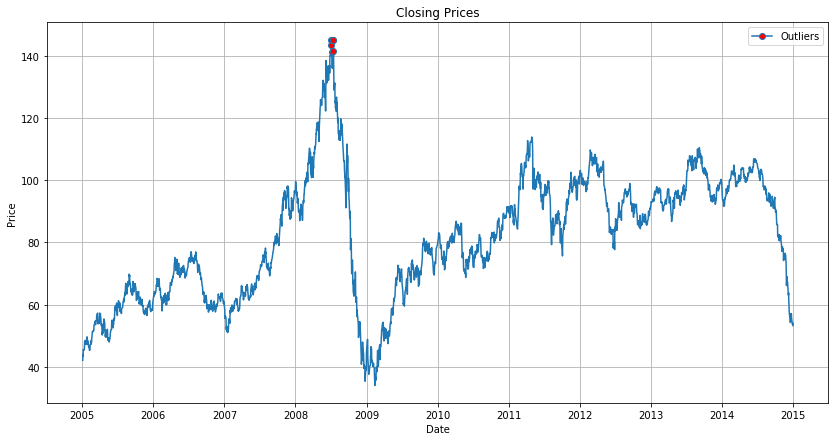

Number of data points: 2517
Number of outliers: 6


In [28]:
check_outliers(cl)

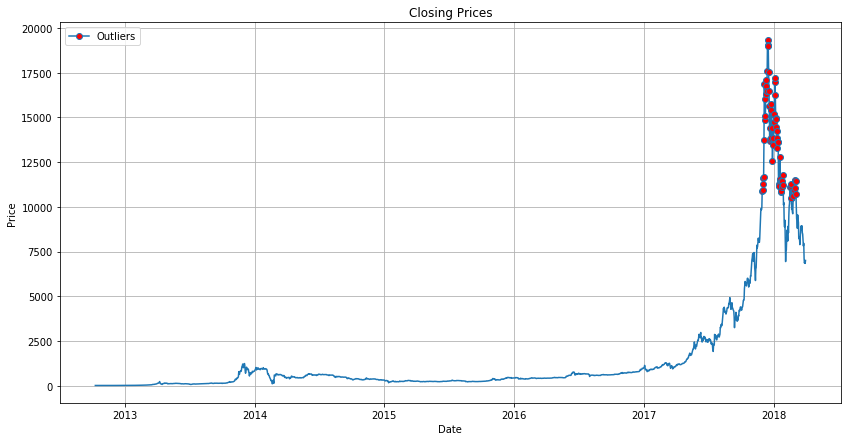

Number of data points: 2001
Number of outliers: 71


In [29]:
check_outliers(btc)

Each market has its outliers but they were due to the market itself making a strong move away from the mean value for the entire time series.  This is not uncommon for commodities and cryptocurrencies.  

In looking at the chart and having experience with these products I am comfortable saying that none of the points are far off due to inaccurate data.

At this point I am comfortable with the data and therefore can insert it into the database.  Then it will be time to move on to manipulation, by creating new columns for the indicators that I want to explore.

Here is the script for entering the data into the **Daily_Prices** table of the SQL database.

In [26]:
# Set table_name
table_name = 'Daily_Prices'

# Create the column name list for database insertion
cols = ['data_id', 'symbol', 'date', 'open', 'high', 'low', 'close', 'volume']

# Open a connection to the database
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Iterate through all symbols and then the dataframe to get all price data
for symbol, df in prod_dict.items():
    data_id = products[symbol][0]
    
    for i, row in df.iterrows():
        date = i.strftime('%Y-%m-%d')
        # Set params and insert row into database
        params = (data_id, symbol, date, row.open, row.high, row.low, row.close, row.volume)
        c.execute("INSERT INTO {tn} ({c0}, {c1}, {c2}, {c3}, {c4}, {c5}, {c6}, {c7}) VALUES (?, ?, ?, ?, ?, ?, ?, ?)"\
            .format(tn=table_name, c0=cols[0], c1=cols[1], c2=cols[2], c3=cols[3], c4=cols[4],\
            c5=cols[5], c6=cols[6], c7=cols[7]), params)

# Close connection to database
conn.commit()
conn.close()

## Data Manipulation

The next step in the analysis is to add columns to each product's dataframe to represent the specific indicators that we are interested in observing.  These can all be calculated from the current, **open, high, low, close, volume** data that we have.  

We also want to add columns that track future price changes.  I am choosing to look at a few different time frames, next day, 5 days out, 10 days out, and 20 days out.  Once we have columns for each indicator as a binary (0 if no signal, 1 if signal) and columns for the future returns from that point we can analyze which (if any) of the indicators shows promise for consistently predicting future returns.

Below is the code to add each column we need.  In the end, just passing a dataframe which is formatted as we have setup in the above analysis to the `add_all_indicators` function will do all the work.

In [30]:
def vol_bo(row, direction):
    ''' This is a helper function to use in volume breakout column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if row['volume'] > (2 * row['20day_ave_vol']):
        if (direction == 'long') and (row['close_gt_prev_h'] > 0.0):
            return 1
        elif (direction == 'short') and (row['close_lt_prev_l'] < 0.0):
            return 1
        else:
            return 0

def range_bo(row, direction):
    ''' This is a helper function to use in range breakout column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['high'] > row['20day_high']:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['low'] < row['20day_low']:
            return 1
        else:
            return 0

def ma_signal(row, ma, direction):
    ''' This is a helper function to use in all moving average columns creation.  It takes
        in a row of a dataframe, a length of time and a direction of trade, and returns
        1 if a breakout has occured, 0 if not.

        Args: row - row of a dataframe
              ma - length of time for moving average
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['close'] > row['ma{}'.format(ma)]:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['close'] < row['ma{}'.format(ma)]:
            return 1
        else:
            return 0

def bb_signal(row, direction):
    ''' This is a helper function to use in all bollinger band column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['low'] < row['bb_low']:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['high'] > row['bb_high']:
            return 1
        else:
            return 0

def add_all_indicators(df):
    ''' This function takes in a cleaned dataframe of price information and uses
        the helper functions to add all relevant indicators as columns
        to the dataframe.

        Args: df - cleaned dataframe of price information

        Return: df - cleaned dataframe with added columns for all indicators
    '''
    # All columns for 20day volume breakout indicator
    df['20day_ave_vol'] = df.volume.rolling(window=20, center=False).mean().shift(1)
    df['close_gt_prev_h'] = df['close'] - df['high'].shift(1)
    df['close_lt_prev_l'] = df['close'] - df['low'].shift(1)
    df['vol_bo_long'] = df.apply(lambda row: vol_bo(row, direction='long'), axis=1)
    df['vol_bo_short'] = df.apply(lambda row: vol_bo(row, direction='short'), axis=1)
    df['vol_bo_long'].fillna(value=0, inplace=True)
    df['vol_bo_short'].fillna(value=0, inplace=True)

    # All columns for 20day range breakout indicator
    df['20day_high'] = df.high.rolling(window=20, center=False).max().shift(1)
    df['20day_low'] = df.low.rolling(window=20, center=False).min().shift(1)
    df['range_bo_long'] = df.apply(lambda row: range_bo(row, direction='long'), axis=1)
    df['range_bo_short'] = df.apply(lambda row: range_bo(row, direction='short'), axis=1)

    # All columns for moving average indicators
    df['ma20'] = df['close'].rolling(window=20, center=False).mean()
    df['ma50'] = df['close'].rolling(window=50, center=False).mean()
    df['ma100'] = df['close'].rolling(window=100, center=False).mean()
    df['ma20_long'] = df.apply(lambda row: ma_signal(row, ma=20, direction='long'), axis=1)
    df['ma20_short'] = df.apply(lambda row: ma_signal(row, ma=20, direction='short'), axis=1)
    df['ma50_long'] = df.apply(lambda row: ma_signal(row, ma=50, direction='long'), axis=1)
    df['ma50_short'] = df.apply(lambda row: ma_signal(row, ma=50, direction='short'), axis=1)
    df['ma100_long'] = df.apply(lambda row: ma_signal(row, ma=100, direction='long'), axis=1)
    df['ma100_short'] = df.apply(lambda row: ma_signal(row, ma=100, direction='short'), axis=1)

    # All columns for bollinger band indicators
    df['bb_high'] = df['ma20'] + (2 * df['close'].rolling(window=20, center=False).std())
    df['bb_low'] = df['ma20'] - (2 * df['close'].rolling(window=20, center=False).std())
    df['bb_long'] = df.apply(lambda row: bb_signal(row, direction='long'), axis=1)
    df['bb_short'] = df.apply(lambda row: bb_signal(row, direction='short'), axis=1)

    # All columns for percentage change for timeframe into the future
    df['pct_change_1day'] = df['close'].pct_change()
    df['pct_change_5day'] = df['close'].pct_change(periods=5)
    df['pct_change_10day'] = df['close'].pct_change(periods=10)
    df['pct_change_20day'] = df['close'].pct_change(periods=20)

    return df

Lets check out how it works for Crude Oil and Bitcoin

In [31]:
cl.head()

,open,high,low,close,volume
Date,,,,,
2005-01-03,43.10,43.10,41.25,42.12,69484.0
2005-01-04,42.18,44.13,41.85,43.91,100665.0
2005-01-05,43.90,44.00,42.60,43.39,91011.0
2005-01-06,43.39,45.75,42.80,45.56,122411.0
2005-01-07,45.50,46.10,44.75,45.43,99725.0


In [34]:
cl_indicators = add_all_indicators(cl)
cl_indicators.tail()

,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,358766.18,-1.72,0.78,0.0,0.0,...,0,1,72.792675,50.138525,0,0,-0.022409,-0.013393,-0.083689,-0.246322
2014-12-26,55.86,56.59,54.51,54.73,138280.0,352792.28,-2.42,-0.34,0.0,0.0,...,0,1,70.647242,50.387958,0,0,-0.019878,0.008662,-0.087073,-0.257294
2014-12-29,55.05,55.74,52.90,53.61,253089.0,346788.83,-2.98,-0.90,0.0,0.0,...,0,1,70.104360,49.676840,0,0,-0.020464,-0.059606,-0.072652,-0.189569
2014-12-30,53.72,54.32,52.70,54.12,230228.0,331802.13,-1.62,1.22,0.0,0.0,...,0,1,68.713782,49.579418,0,0,0.009513,-0.020630,-0.032016,-0.215652
2014-12-31,53.87,54.02,52.44,53.27,247510.0,317298.38,-1.05,0.57,0.0,0.0,...,0,1,67.645476,49.286724,0,0,-0.015706,-0.067402,-0.048682,-0.203499


In [35]:
cl_indicators.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2517.0,81.796207,19.832869,34.360000,65.680000,82.550000,96.900000,145.190000
high,2517.0,82.893532,19.961713,36.250000,66.560000,83.720000,97.820000,147.270000
low,2517.0,80.582003,19.695067,33.550000,64.650000,81.250000,95.560000,143.220000
close,2517.0,81.779758,19.855341,33.980000,65.820000,82.550000,96.920000,145.290000
volume,2517.0,242044.416712,95788.999248,50742.000000,176838.400000,242868.000000,301777.000000,670082.000000
20day_ave_vol,2497.0,242391.874480,77703.758445,89659.910000,213491.190000,249613.120000,293932.000000,436907.800000
close_gt_prev_h,2516.0,-1.109487,1.958492,-12.200000,-2.040000,-0.856000,0.080000,10.160000
close_lt_prev_l,2516.0,1.202332,1.864001,-8.680000,0.159500,1.088000,2.230000,16.930000
vol_bo_long,2517.0,0.000397,0.019932,0.000000,0.000000,0.000000,0.000000,1.000000
vol_bo_short,2517.0,0.001589,0.039841,0.000000,0.000000,0.000000,0.000000,1.000000


And for Bitcoin

In [36]:
btc.head()

,open,high,low,close,volume
Date,,,,,
2012-10-09,11.90,12.19,11.77,12.12,333351.59
2012-10-10,12.12,12.15,11.86,12.03,238483.07
2012-10-11,12.03,12.15,11.92,12.00,259522.53
2012-10-12,12.00,12.11,11.85,11.86,141870.31
2012-10-13,11.86,12.03,11.50,11.74,271135.83


In [37]:
btc_indicators = add_all_indicators(btc)
btc.tail()

,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-28,7959.78,7983.77,6927.11,7106.62,1.379180e+09,1.166837e+09,-1011.17,-645.98,0.0,0.0,...,0,1,9617.095099,7350.457901,1,0,-0.107184,-0.168628,-0.175866,-0.231946
2018-03-29,7106.62,7280.27,6595.26,6853.76,1.584675e+09,1.131715e+09,-1130.01,-73.35,0.0,0.0,...,0,1,9722.010776,7051.191224,1,0,-0.035581,-0.191091,-0.231702,-0.220922
2018-03-30,6853.75,7228.40,6806.34,6943.77,9.154006e+08,1.156703e+09,-336.50,348.51,0.0,0.0,...,0,1,9623.274823,6889.820177,1,0,0.013133,-0.148234,-0.220795,-0.272511
2018-03-31,6943.77,7056.22,6463.54,6835.84,8.898877e+08,1.133732e+09,-392.56,29.50,0.0,0.0,...,0,1,9580.595654,6701.868346,1,0,-0.015543,-0.124562,-0.216521,-0.252272
2018-04-01,6835.58,6999.52,6792.30,6999.52,1.342822e+07,1.106456e+09,-56.70,535.98,0.0,0.0,...,0,1,9474.901335,6591.502665,0,0,0.023944,-0.120639,-0.216600,-0.235870


In [38]:
btc_indicators.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2001.0,1.487164e+03,2.991797e+03,10.170000,2.358300e+02,4.426600e+02,8.941600e+02,1.934660e+04
high,2001.0,1.547409e+03,3.131154e+03,10.650000,2.400100e+02,4.533700e+02,9.202600e+02,1.987062e+04
low,2001.0,1.416433e+03,2.809985e+03,9.740000,2.317800e+02,4.311000e+02,8.483200e+02,1.875091e+04
close,2001.0,1.490659e+03,2.994143e+03,10.170000,2.358500e+02,4.431800e+02,8.944100e+02,1.934549e+04
volume,2001.0,1.692008e+08,4.810454e+08,109479.890000,3.945871e+06,1.531576e+07,4.761919e+07,6.245732e+09
20day_ave_vol,1981.0,1.658894e+08,4.370941e+08,268276.273500,4.378482e+06,1.669031e+07,4.653547e+07,2.907625e+09
close_gt_prev_h,2000.0,-5.328476e+01,2.936127e+02,-3636.860000,-1.909500e+01,-4.935000e+00,4.500000e-01,3.007110e+03
close_lt_prev_l,2000.0,7.765303e+01,3.262824e+02,-2134.220000,1.267500e+00,7.775000e+00,3.240500e+01,5.188550e+03
vol_bo_long,2001.0,4.397801e-02,2.050975e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
vol_bo_short,2001.0,2.098951e-02,1.433849e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Now lets take a look at a simple bar plot showing the number of trade signals for each strategy.

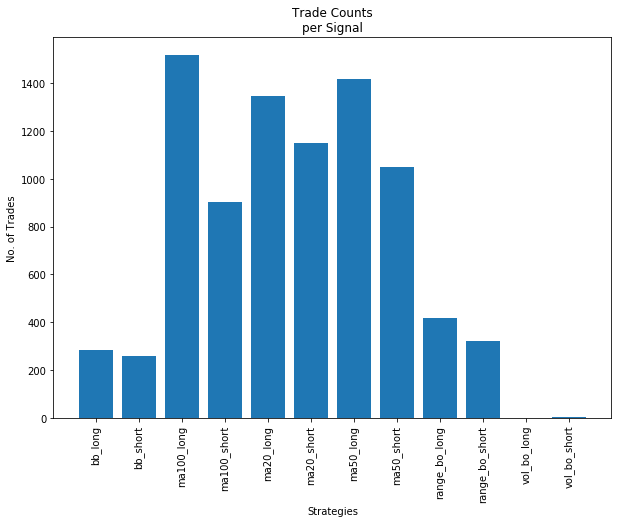

In [46]:
# Get the trade signal columns of the dataframe
cl_signals = cl_indicators[['vol_bo_long', 'vol_bo_short', 'range_bo_long', 'range_bo_short',
                       'ma20_long', 'ma20_short', 'ma50_long', 'ma50_short', 'ma100_long',
                       'ma100_short', 'bb_long', 'bb_short']]

# Put the strategy names and counts into lists
signal_names = [signal for signal in cl_signals.columns]
signal_counts = [cl_signals[signal].value_counts()[1] for signal in cl_signals.columns]

# Plot 
plt.figure(figsize=(10,7))
plt.bar(signal_names, signal_counts)
plt.title('Trade Counts\nper Signal')
plt.xlabel('Strategies')
plt.ylabel('No. of Trades')
plt.xticks(rotation=90)

plt.savefig('crude_trade_counts.png', bbox_inches='tight')
plt.show()

And for Bitcoin

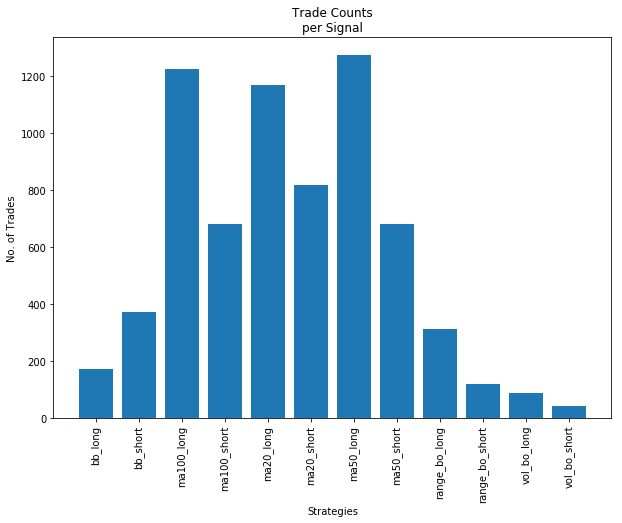

In [47]:
# Get the trade signal columns of the dataframe
btc_signals = btc_indicators[['vol_bo_long', 'vol_bo_short', 'range_bo_long', 'range_bo_short',
                       'ma20_long', 'ma20_short', 'ma50_long', 'ma50_short', 'ma100_long',
                       'ma100_short', 'bb_long', 'bb_short']]

# Put the strategy names and counts into lists
signal_names = [signal for signal in btc_signals.columns]
signal_counts = [btc_signals[signal].value_counts()[1] for signal in btc_signals.columns]

# Plot 
plt.figure(figsize=(10,7))
plt.bar(signal_names, signal_counts)
plt.title('Trade Counts\nper Signal')
plt.xlabel('Strategies')
plt.ylabel('No. of Trades')
plt.xticks(rotation=90)

plt.savefig('bitcoin_trade_counts.png', bbox_inches='tight')
plt.show()